# Знакомство с Pennylane

В качестве знакомства с [Pennylane](https://pennylane.ai/) разберём туториал [Pennylane qubit rotation](https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html), в котором предлагается реализовать простую схему, состоящую из последовательного применения операторов вращения:

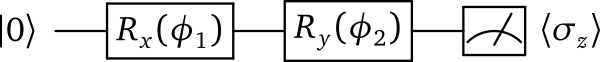

... но в начале [установим](https://pennylane.ai/install.html) его:

In [2]:
# !pip install pennylane --upgrade
# !pip install pennylane-qiskit

In [6]:
# TODO: описание задачи

In [3]:
import pennylane as qml
from pennylane import numpy as np

Начальная точка программы на Pennylane - создание device, который является аналогом бекэнда в Qiskit

In [5]:
dev1 = qml.device("default.qubit", wires=1)

Следующий кирпичик - QNode -  аналог объекта circuit в Qiskit. По сути, это функция, в которой обозначены операции на квантовой схеме

In [29]:
@qml.qnode(dev1) # connect circuit to the created device
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))

In [30]:
print(circuit([0.54, 0.12]))

0.8515405859048366


## Calculating quantum gradients and optimization

Следующая часть туториала - подсчёт градиента. Градиент берётся сразу по функци `circuit`:

In [24]:
dcircuit  = qml.grad(circuit, argnum=0)

In [25]:
print(dcircuit([0.54, 0.12]))

[array(-0.51043865), array(-0.1026782)]


А теперь придумаем задачу оптимизации и решим её.  Заоптимизируем два параметра $\phi_1$ и $\phi_2$, которые задают параметры поворот, таким образом, чтобы вектор состояния кубита перешёл из состояния $|0\rangle$ в состояние $|1\rangle$.

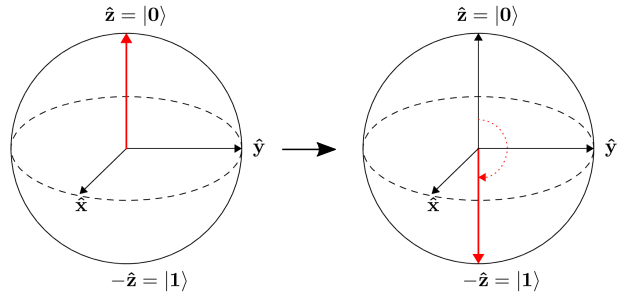

При измерении по оси $Z$ наблюдаемое значение кубита всегда будет давать нам [одно из двух значений](https://semyonsinchenko.github.io/qmlcourse/_build/html/book/qcblock/qubit.html#hat-sigma-z): $1$ или $-1$, которые являются собственными числами [оператору Паули в базисе $Z$](https://semyonsinchenko.github.io/qmlcourse/_build/html/book/qcblock/qubit.html#id24). Каждое из значений соответсвует своему собственному вектору. Значению $\lambda=1$ ставится в соответствие собственный вектор $[1,0]^T$, значению  $\lambda=-1$ - вектор $[0,1]^T$, (обыкновенные пары собственых чисел и векторов для матрицы оператора). 
При измерении кубита по $Z$, его вектор состояний будет переходит в одно из этих двух собственных вектора.

Так как наша задача состоит в том, чтобы после измерения кубит перешёл в состояние $|1\rangle$, то [ожидаемое значение при измерении](https://semyonsinchenko.github.io/qmlcourse/_build/html/book/qcblock/qubit.html#id28) оператора Паули Z , будет равно $-1$

Чтобы что-то оптимизирвать нужная целевая функция. В качестве неё будет использовать прямой выход нашей схемы:

In [26]:
def cost(x):
    return circuit(x)

Последняя операция - применения оператора Паули, рещультат которого ограничен $[-1,1]$. Минимизируя функцию, мы дойдём до нижней границы, а значит состояние кубита станет равным  $|1\rangle$

In [31]:
init_params = np.array([0.011, 0.012], requires_grad=True)
print(cost(init_params))

0.9998675058299389


Случайные значения параметров дают результат близкий к $1$. Настало время оптимизации, чтобы превратить его в $-1$

In [32]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 100
# set the initial parameter values
params = init_params

for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))

Cost after step     5:  0.9961778
Cost after step    10:  0.8974944
Cost after step    15:  0.1440490
Cost after step    20: -0.1536720
Cost after step    25: -0.9152496
Cost after step    30: -0.9994046
Cost after step    35: -0.9999964
Cost after step    40: -1.0000000
Cost after step    45: -1.0000000
Cost after step    50: -1.0000000
Cost after step    55: -1.0000000
Cost after step    60: -1.0000000
Cost after step    65: -1.0000000
Cost after step    70: -1.0000000
Cost after step    75: -1.0000000
Cost after step    80: -1.0000000
Cost after step    85: -1.0000000
Cost after step    90: -1.0000000
Cost after step    95: -1.0000000
Cost after step   100: -1.0000000
Optimized rotation angles: [7.15266381e-18 3.14159265e+00]


Смотрим, что вышло:

In [36]:
print(circuit([ 0,np.pi]))

-1.0


In [37]:
print(circuit([ np.pi,0]))

-1.0
